In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from IPython.display import Markdown
from pycaret.classification import setup

# Exploratory Data Analysis (EDA) – Iris Dataset

The *Iris Dataset* (also known as Fisher’s Iris Dataset) is a classic and widely used dataset in data analysis and machine learning. It includes measurements of four morphological features for three species of iris flowers: Setosa, Versicolor, and Virginica.

**Objective**: To assess whether it is possible to distinguish iris species based on their morphological features — in particular, the dimensions of petals and sepals.

In [2]:
df = sns.load_dataset('iris')

sns.set(style="whitegrid")

## Basic Information

In [3]:
Markdown(f"""
### The dataset contains **{len(df)}** rows and **{len(df.columns)}** columns
""")


### The dataset contains **150** rows and **5** columns


In [4]:
def vivid_flower_colors(row):
    color_map = {
        'setosa': 'background-color: #FFB6C1; color: black;',
        'versicolor': 'background-color: #A569BD; color: white;',
        'virginica': 'background-color: #56BAFC; color: white;'
    }
    return [color_map.get(row['species'], '')] * len(row)

df.sample(8, random_state=77).style.apply(vivid_flower_colors, axis=1)

,sepal_length,sepal_width,petal_length,petal_width,species
82,5.800000,2.700000,3.900000,1.200000,versicolor
133,6.300000,2.800000,5.100000,1.500000,virginica
113,5.700000,2.500000,5.000000,2.000000,virginica
93,5.000000,2.300000,3.300000,1.000000,versicolor
5,5.400000,3.900000,1.700000,0.400000,setosa
114,5.800000,2.800000,5.100000,2.400000,virginica
128,6.400000,2.800000,5.600000,2.100000,virginica
119,6.000000,2.200000,5.000000,1.500000,virginica


In [5]:
df['species'] = df['species'].astype('category')

In [6]:
species_counts = df['species'].value_counts()
species_lines = "\n".join([
    f"- **{species}**: {count} samples" for species, count in species_counts.items()
])

Markdown(f"""
### The most important column in the dataset is `species`, which contains labels for **{species_counts.size}** iris species:
{species_lines}
""")


### The most important column in the dataset is `species`, which contains labels for **3** iris species:
- **setosa**: 50 samples
- **versicolor**: 50 samples
- **virginica**: 50 samples


In [7]:
features = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

## cm to mm
df[features] = (df[features]*10).round(0).astype(int)

For each flower, the dataset includes:
- **Sepal length** (in mm)
- **Sepal width** (in mm)
- **Petal length** (in mm)
- **Petal width** (in mm)

In [8]:
# df.isnull().sum()

Markdown(f"""
There are **{df.isnull().sum().sum()}** missing values in the dataset
""")


There are **0** missing values in the dataset


In [9]:
df = df.drop_duplicates(keep='first')

## Visual Analysis

### Feature Medians by Species – Chart 1

This chart presents the median values of all four features (sepal length, sepal width, petal length, and petal width) for each species. The median is the middle value — it represents a typical measurement for that species.

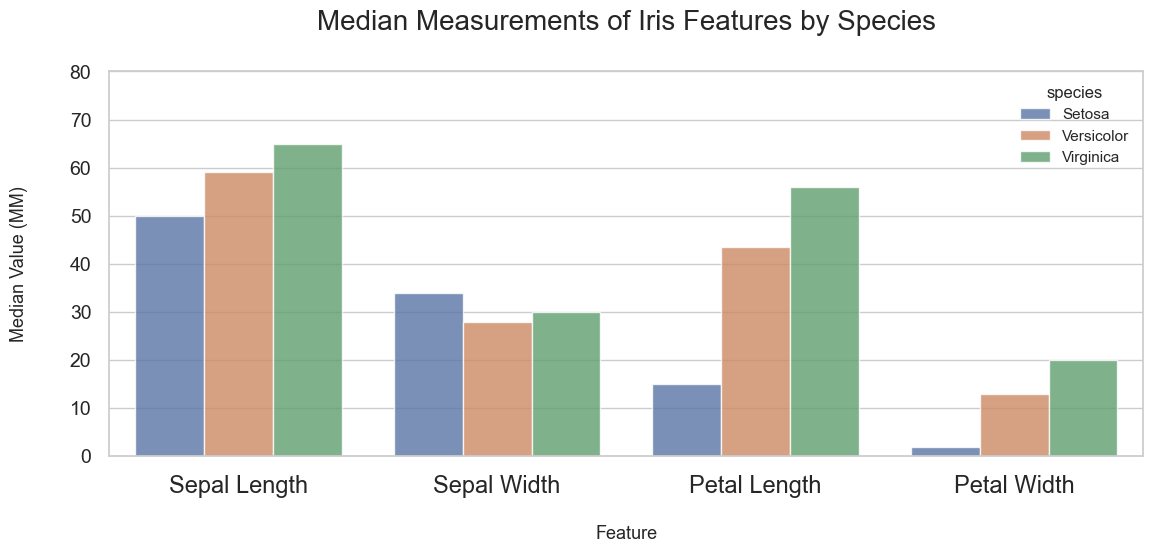

In [10]:
features = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
medians = df.groupby('species')[features].median().reset_index()

medians_melted = medians.melt(id_vars='species', var_name='feature', value_name='median_value')
medians_melted['feature'] = medians_melted['feature'].str.replace('_', ' ').str.title()
medians_melted['species'] = medians_melted['species'].str.title()

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(
    data=medians_melted, 
    x='feature', 
    y='median_value', 
    hue='species', 
    alpha=0.8, 
    ax=ax
)

ax.set_title('Median Measurements of Iris Features by Species', fontsize=20, pad=30)
ax.set_xlabel('Feature', fontsize=13, labelpad=20)
ax.set_ylabel('Median Value (MM)', fontsize=13, labelpad=30)

ax.set_ylim(0, 80)
ax.grid(True, axis='y', linestyle='-', alpha=1)
plt.xticks(fontsize=17)
plt.yticks(fontsize=14)

plt.tight_layout(pad=2)
plt.show()

**Insights**:
- *Iris Setosa* has much shorter and narrower petals than the other two species.
- *Iris Virginica* has the longest petals and sepals overall.
- *Iris Versicolor* lies in between — acting as a transition form.
- Even at this stage, petal length appears to be a strong distinguishing feature between species.

### Feature Medians by Trait – Chart 2 (Rotated View)

This chart shows the same data but from a different perspective — for each feature, it compares medians across all three species.

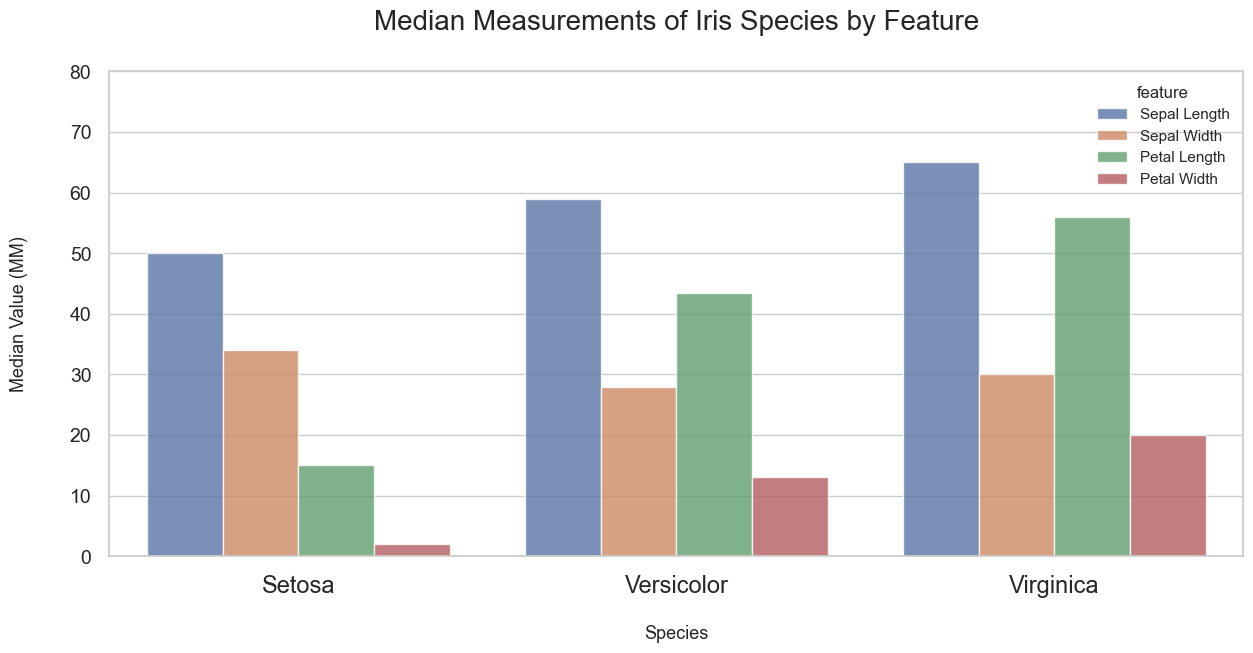

In [11]:
features = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
medians = df.groupby('species')[features].median().reset_index()

medians_melted = medians.melt(id_vars='species', var_name='feature', value_name='median_value')
medians_melted['feature'] = medians_melted['feature'].str.replace('_', ' ').str.title()
medians_melted['species'] = medians_melted['species'].str.title()

fig, ax = plt.subplots(figsize=(13, 7))
sns.barplot(
    data=medians_melted, 
    x='species', 
    y='median_value', 
    hue='feature', 
    alpha=0.8, 
    ax=ax
)

ax.set_title('Median Measurements of Iris Species by Feature', fontsize=20, pad=30)
ax.set_xlabel('Species', fontsize=13, labelpad=20)
ax.set_ylabel('Median Value (MM)', fontsize=13, labelpad=30)

ax.set_ylim(0, 80)
ax.grid(True, axis='y', linestyle='-', alpha=1)
plt.xticks(fontsize=17)
plt.yticks(fontsize=14)

plt.tight_layout(pad=2)
plt.show()

**Insights**:
- Petal length and width differ significantly between species.
- Sepal width shows less distinction — especially between Versicolor and Virginica.

## Feature Distributions and Outlier Analysis

### Boxplots – Feature Distribution by Species

Each boxplot shows how a specific feature is distributed across the three species. The line in the middle of the box indicates the median; the box spans typical values, and dots represent potential outliers.

In [12]:
df_melted = df.melt(id_vars='species', var_name='feature', value_name='value')
df_melted['feature'] = df_melted['feature'].str.replace('_', ' ').str.title()
df_melted['species'] = df_melted['species'].str.title()

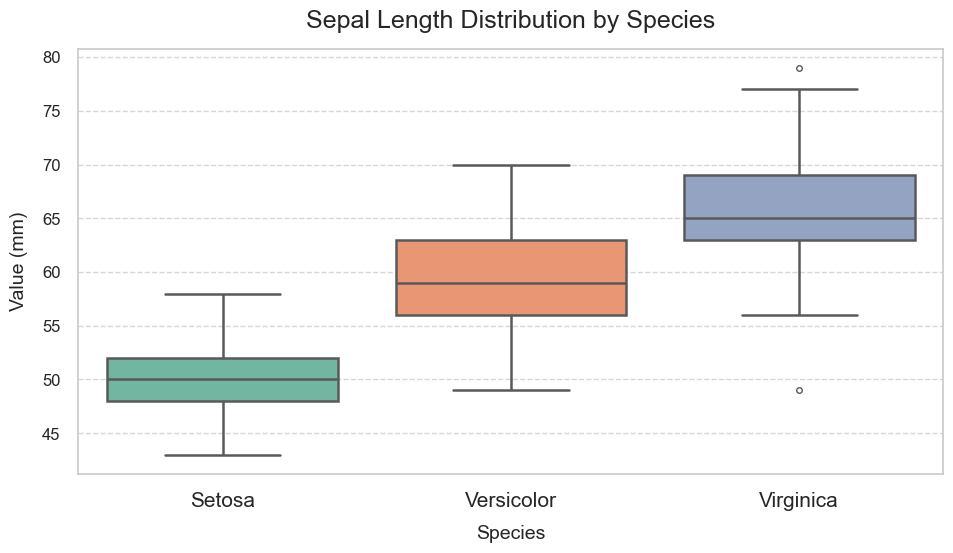

In [13]:
# first
feature = 'Sepal Length'
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(
    data=df_melted[df_melted['feature'] == feature],
    x='species',
    y='value',
    palette='Set2',
    linewidth=1.8,
    fliersize=4,
    ax=ax
)
ax.set_title(f'{feature} Distribution by Species', fontsize=18, pad=15)
ax.set_xlabel('Species', fontsize=14, labelpad=10)
ax.set_ylabel('Value (mm)', fontsize=14, labelpad=10)

ax.grid(axis='y', linestyle='--', alpha=.8)
plt.xticks(fontsize=15)
plt.yticks(fontsize=12)
plt.tight_layout(pad=2)
plt.show()

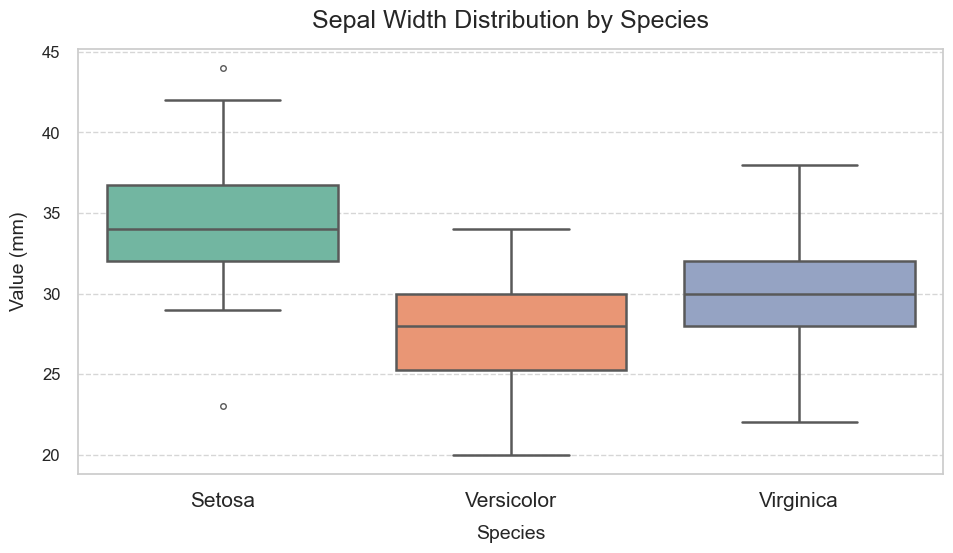

In [14]:
# second
feature = 'Sepal Width'
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(
    data=df_melted[df_melted['feature'] == feature],
    x='species',
    y='value',
    palette='Set2',
    linewidth=1.8,
    fliersize=4,
    ax=ax
)
ax.set_title(f'{feature} Distribution by Species', fontsize=18, pad=15)
ax.set_xlabel('Species', fontsize=14, labelpad=10)
ax.set_ylabel('Value (mm)', fontsize=14, labelpad=10)

ax.grid(axis='y', linestyle='--', alpha=.8)
plt.xticks(fontsize=15)
plt.yticks(fontsize=12)
plt.tight_layout(pad=2)
plt.show()

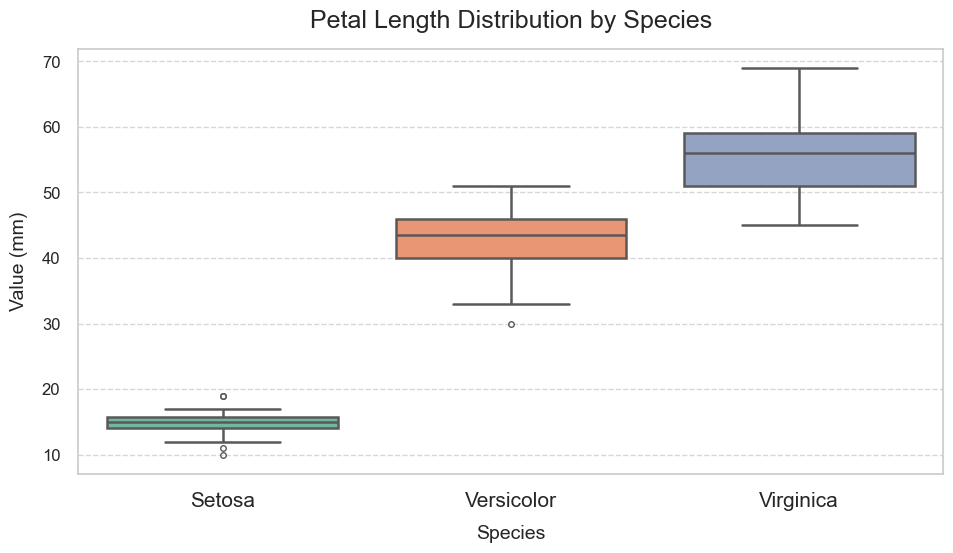

In [15]:
# third
feature = 'Petal Length'
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(
    data=df_melted[df_melted['feature'] == feature],
    x='species',
    y='value',
    palette='Set2',
    linewidth=1.8,
    fliersize=4,
    ax=ax
)
ax.set_title(f'{feature} Distribution by Species', fontsize=18, pad=15)
ax.set_xlabel('Species', fontsize=14, labelpad=10)
ax.set_ylabel('Value (mm)', fontsize=14, labelpad=10)

ax.grid(axis='y', linestyle='--', alpha=.8)
plt.xticks(fontsize=15)
plt.yticks(fontsize=12)
plt.tight_layout(pad=2)
plt.show()

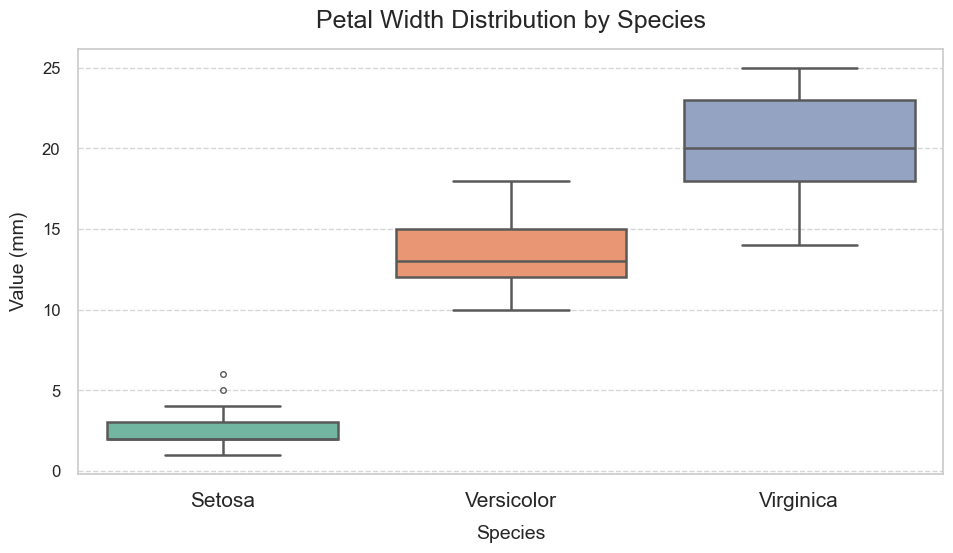

In [16]:
# fourth
feature = 'Petal Width'
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(
    data=df_melted[df_melted['feature'] == feature],
    x='species',
    y='value',
    palette='Set2',
    linewidth=1.8,
    fliersize=4,
    ax=ax
)
ax.set_title(f'{feature} Distribution by Species', fontsize=18, pad=15)
ax.set_xlabel('Species', fontsize=14, labelpad=10)
ax.set_ylabel('Value (mm)', fontsize=14, labelpad=10)

ax.grid(axis='y', linestyle='--', alpha=.8)
plt.xticks(fontsize=15)
plt.yticks(fontsize=12)
plt.tight_layout(pad=2)
plt.show()

**Insights**:
- Petal length and petal width are highly discriminative — Setosa’s values do not overlap with the other two species.
- Sepal width shows overlapping distributions — it may be less useful for classification.
- A few outliers are present, but overall the data appears clean and well-structured.

## Relationships Between Features

### Correlation Matrix

A correlation matrix shows how strongly the features are related to one another (values range from -1 to 1).

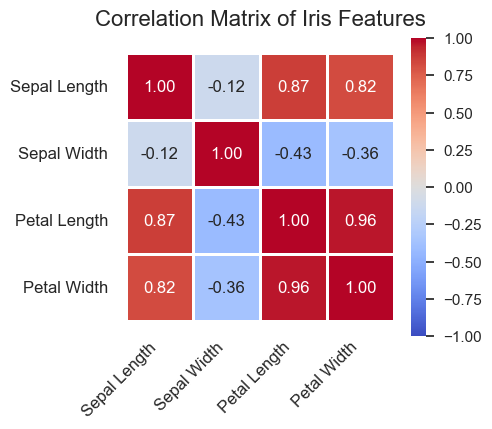

In [17]:
features = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
correlation_matrix = df[features].corr()

# replace underscores and capitalize feature names for better readability
readable_labels = [col.replace('_', ' ').title() for col in correlation_matrix.columns]
correlation_matrix.columns = readable_labels
correlation_matrix.index = readable_labels

plt.figure(figsize=(5, 5))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, square=True,
            cbar_kws={"shrink": .75}, linewidths=1, linecolor='white')

plt.title('Correlation Matrix of Iris Features', fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()
plt.show()

**Insights**:
- The strongest correlation is between petal length and petal width (`0.96`) — these grow together.
- Sepal length is moderately correlated with petal length (`0.87`), suggesting flowers with longer sepals tend to have longer petals.
- There’s also a notable correlation between sepal length and petal width (`0.82`).

## Dimensionality Reduction

### PCA – Principal Component Analysis

Principal Component Analysis (PCA) reduces the dataset to two dimensions while preserving as much variance as possible. Each point in the plot represents a flower, colored by species.

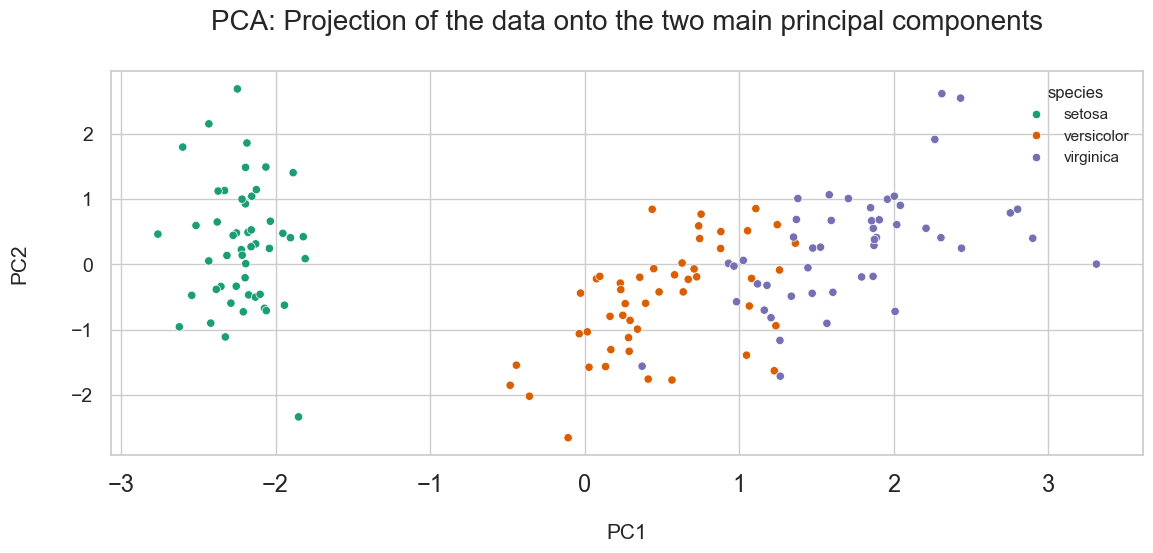

In [18]:
X = df.drop('species', axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['species'] = df['species']

fig, ax = plt.subplots(figsize=(12, 6))
sns.scatterplot(
    data=df_pca, 
    x='PC1', 
    y='PC2', 
    hue='species', 
    palette='Dark2'
)

ax.set_title("PCA: Projection of the data onto the two main principal components", fontsize=20, pad=30)
ax.set_xlabel('PC1', fontsize=15, labelpad=20)
ax.set_ylabel('PC2', fontsize=15, labelpad=30)

ax.grid(True, axis='y', linestyle='-', alpha=1)
plt.xticks(fontsize=17)
plt.yticks(fontsize=14)

plt.tight_layout(pad=2)
plt.show()

**Insights**:
- The three species form distinct clusters — especially *Setosa*, which is clearly separated.
- *Versicolor* and *Virginica* are closer together but still partially separable.
- PCA confirms that the dataset is well-structured and likely suitable for accurate classification.

## Feature Importance

### Which Features Matter Most?

To objectively evaluate which features are most important for distinguishing between iris species, a classification model was trained and the resulting feature importances were analyzed.

In [19]:
exp = setup(
    data=df,
    target='species',
    session_id=77,
    verbose=False
)

In [20]:
# exculde all models without feature_importances_ and coef_
model = exp.compare_models(
    exclude=['qda', 'lda', 'nb', 'knn', 'svm', 'ridge', 'dummy'], verbose=False
)

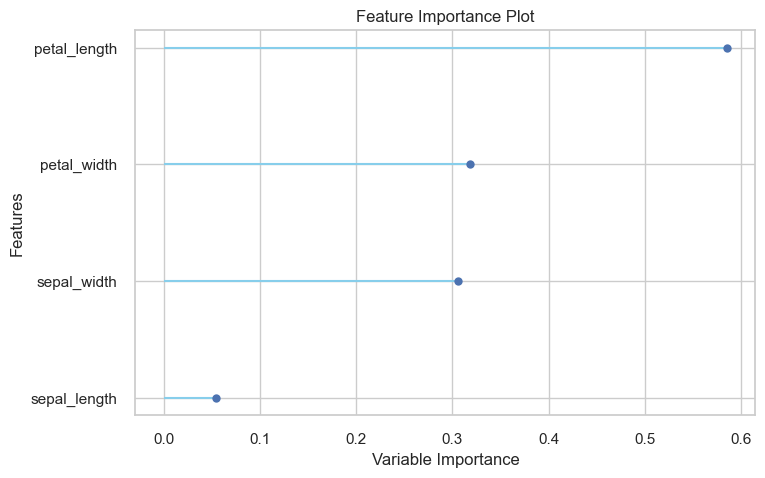

In [21]:
exp.plot_model(model, plot='feature')

**Insights**:
- **Petal Length (0.58)** is the most important feature for classification.
- **Petal Width** and **Sepal Width** also contribute meaningfully, with similar importance scores.
- **Sepal Length (0.06)** has minimal importance — it adds little to distinguishing the species.

## Final Conclusions

- Petal measurements — especially **petal length** — are the most useful features for species classification.
- *Iris Setosa* is the most distinct species, characterized by its short, narrow petals and relatively wide sepals.
- *Iris Virginica* and *Versicolor* are more similar but can still be separated based on petal size.
- Sepal width is the only feature where Setosa scores higher than the other species, making it a unique trait.
- High correlations between petal length and width suggest these dimensions grow proportionally.
- A machine learning model confirmed that petal dimensions are the most important features for species identification.
- With just four simple measurements, we can accurately distinguish between three iris species — a testament to how effectively nature encodes species differences into physical traits.

In [ ]:
# Export the report to /reports/html/iris-eda-report.html, then print it to PDF

# !jupyter nbconvert --to html --no-input --no-prompt ./notebooks/iris-eda-report.ipynb --output ../reports/html/iris-eda-report.html

In [ ]:
# Convert the notebook to a slide deck (slides.html) to /reports/html/iris-eda-report.slides.html

# !jupyter nbconvert iris-eda-report.ipynb --to slides --SlidesExporter.reveal_transition=fade --SlidesExporter.reveal_scroll=True --no-input --output ../reports/html/iris-eda-report

In [ ]:
# Then print it to PDF (?print-pdf)
# iris-eda/reports/html/iris-eda-report.slides.html?print-pdf